In [1]:
# Import required libraries for segmentation
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned retail data
df = pd.read_csv("../data/processed/cleaned_retail.csv")

# Preview data
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSales,Year,Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010,12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010,12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12


In [2]:
# Group transaction-level data to customer-level
# Frequency = number of unique invoices per customer
# Monetary = total spending per customer

customer_df = df.groupby("CustomerID").agg({
    "InvoiceNo": "nunique",
    "TotalSales": "sum"
})

# Rename columns to meaningful names
customer_df.rename(columns={
    "InvoiceNo": "Frequency",
    "TotalSales": "Monetary"
}, inplace=True)

# Preview customer-level dataset
customer_df.head()


,Frequency,Monetary
CustomerID,,
12346.0,1,77183.60
12347.0,7,4310.00
12348.0,4,1797.24
12349.0,1,1757.55
12350.0,1,334.40


In [3]:
# Check summary statistics before scaling
customer_df.describe()


,Frequency,Monetary
count,4338.000000,4338.000000
mean,4.272015,2048.692230
std,7.697998,8985.229676
min,1.000000,3.750000
25%,1.000000,306.482500
50%,2.000000,668.570000
75%,5.000000,1660.597500
max,209.000000,280206.020000


In [4]:
# Import scaler
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Scale Frequency and Monetary values
scaled_data = scaler.fit_transform(customer_df)

# Convert scaled data to DataFrame for readability
scaled_df = pd.DataFrame(
    scaled_data,
    columns=["Frequency_scaled", "Monetary_scaled"],
    index=customer_df.index
)

# Preview scaled data
scaled_df.head()


,Frequency_scaled,Monetary_scaled
CustomerID,,
12346.0,-0.425097,8.363010
12347.0,0.354417,0.251698
12348.0,-0.035340,-0.027988
12349.0,-0.425097,-0.032406
12350.0,-0.425097,-0.190812


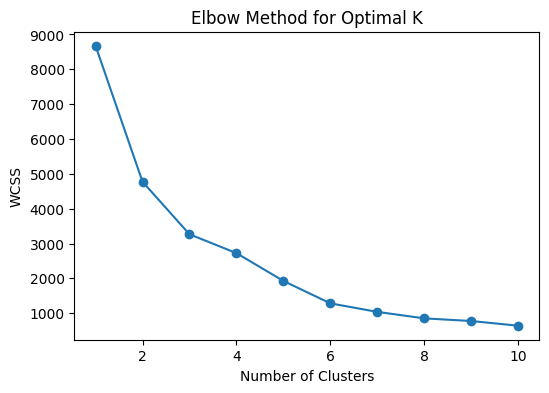

In [5]:
# Import KMeans
from sklearn.cluster import KMeans

# List to store WCSS values
wcss = []

# Try different cluster sizes
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df)
    wcss.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(6,4))
plt.plot(range(1, 11), wcss, marker="o")
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()


In [6]:
# Initialize KMeans with optimal number of clusters (K=3)
kmeans = KMeans(n_clusters=3, random_state=42)

# Fit model and predict clusters
customer_df["Cluster"] = kmeans.fit_predict(scaled_df)

# Preview clustered data
customer_df.head()


,Frequency,Monetary,Cluster
CustomerID,,,
12346.0,1,77183.60,2
12347.0,7,4310.00,0
12348.0,4,1797.24,0
12349.0,1,1757.55,0
12350.0,1,334.40,0


In [7]:
# Calculate average Frequency and Monetary value per cluster
cluster_summary = customer_df.groupby("Cluster").mean()

# Display cluster summary
cluster_summary


,Frequency,Monetary
Cluster,,
0,3.058421,1096.333157
1,82.538462,127187.959231
2,21.141026,11746.514872


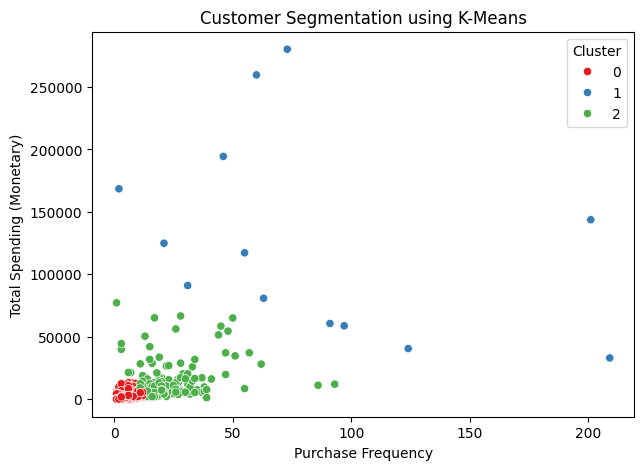

In [8]:
# Scatter plot of customers by Frequency and Monetary value
plt.figure(figsize=(7,5))
sns.scatterplot(
    x=customer_df["Frequency"],
    y=customer_df["Monetary"],
    hue=customer_df["Cluster"],
    palette="Set1"
)

# Add plot labels
plt.title("Customer Segmentation using K-Means")
plt.xlabel("Purchase Frequency")
plt.ylabel("Total Spending (Monetary)")
plt.show()


In [ ]:
# Business interpretation of clusters:
# Cluster 0 -> High-value customers (high frequency & high spending)
# Cluster 1 -> Medium-value customers
# Cluster 2 -> Low-value or one-time buyers


In [9]:
# Save customer segmentation results for future use
customer_df.to_csv("../data/processed/customer_segments.csv")

print("Customer segmentation file saved successfully")


Customer segmentation file saved successfully
